## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory
all_solutions = glob.glob('../temp/FITNESS_SOLUTION_*')
all_generations = glob.glob('../temp/GENERATION_*')
# for i in all_solutions:
#     os.remove(i)
# for j in all_generations:
#     os.remove(j)


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    INP_FILE_PATH = r"../data/Real_Synthetic_Net.inp" 
    TEMP_DIR = "../temp/"
    PLOTS_DIR = "../plots"
    FUNCTION_INPUTS = None
    DESIRED_OUTPUT = None

In [6]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../temp'):
            os.mkdir('../temp')

        if not os.path.exists('../plots'):
            os.mkdir('../plots')


        if not os.path.exists('results'):
            os.mkdir('results')
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=0.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.INP_FILE_PATH)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=leak_area, start_time=start_time, end_time=end_time, discharge_coeff=.5)
        self.simulate(wn, plot_graph=plot_graph)

        self.FUNCTION_INPUTS = function_inputs
        self.DESIRED_OUTPUT = node.head - node.elevation
        

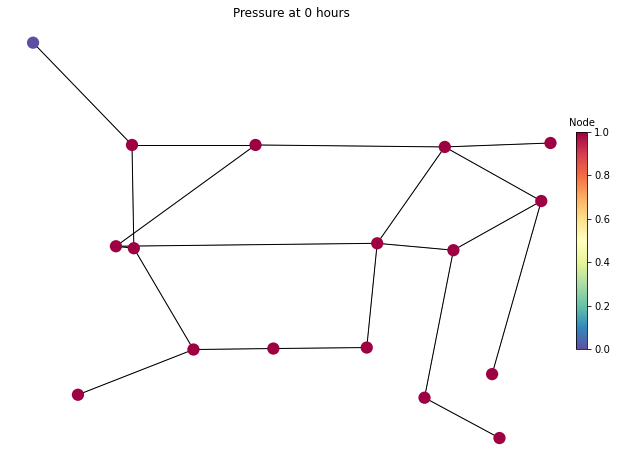

In [7]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.run()

In [8]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model.DESIRED_OUTPUT) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model.TEMP_DIR}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [9]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model.TEMP_DIR}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [10]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=water_model.num_generations,
                       num_parents_mating=water_model.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model.sol_per_pop,
                       num_genes=water_model.num_genes,
                       init_range_low=water_model.init_range_low,
                       init_range_high=water_model.init_range_high,
                       parent_selection_type=water_model.parent_selection_type,
                       keep_parents=water_model.keep_parents,
                       crossover_type=water_model.crossover_type,
                       mutation_type=water_model.mutation_type,
                       mutation_num_genes=water_model.mutation_num_genes,
                       callback_generation=callback_generation)

In [11]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 26.466 |==================| 13.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 26.511 |==================| 34.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 26.522 |==================| 55.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.794 |===========| 26.494 |==================| 21.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 26.534 |==================| 155.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==================| 79.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 26.514 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.602 |==================| 16.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 26.553 |==================| 79.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 26.514 |==================| 38.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |==================| 342.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 26.46 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 26.455 |==================| 11.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |==================| 7.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 26.482 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |==================| 7.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 26.482 |==================| 17.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |==================| 7.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 26.482 |==================| 17.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.811 |===========| 26.491 |==================| 20.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 26.439 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.239 |===========| 26.422 |==================| 8.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |==================| 32.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |==================| 8.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |==================| 9.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |==================| 8.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |==================| 9.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 26.613 |==================| 13.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |==================| 251.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 26.598 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 26.546 |==================| 176.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 523.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 |==================| 17.777 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 26.399 |==================| 7.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.56

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 26.538 |==================| 523.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 26.484 |==================| 17.777 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 26.399 |==================| 7.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 717.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 13.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.317 |===========| 26.409 |==================| 7.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 26.539 |==================| 717.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 26.556 |==================| 62.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 13.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.317 |===========| 26.409 |==================| 7.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 13.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.317 |===========| 26.409 |==================| 7.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 26.572 |==================| 31.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 26.521 |==================| 52.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.258 |===========| 26.419 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.426 |===========| 26.391 |==================| 6.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.041 |===========| 26.454 |==================| 11.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===========| 26.416 |==================| 8.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.426 |===========| 26.391 |==================| 6.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 26.481 |==================| 16.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.041 |===========| 26.454 |==================| 11.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===========| 26.416 |==================| 8.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |==================| 98.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 26.44 |==================| 9.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |==================| 138071.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |==================| 7.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 26.44 |==================| 9.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |==================| 138071.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |==================| 7.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 26.54 |==================| 138071.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 26.414 |==================| 7.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.504 |===========| 26.378 |==================| 6.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.068 |===========| 26.45 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 34.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 26.431 |==================| 9.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |==================| 14.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.08 |===========| 26.448 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 26.431 |==================| 9.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 26.609 |==================| 14.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.08 |===========| 26.448 |==================| 10.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 26.379 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.591 |===========| 26.526 |==================| 69.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 26.476 |==================| 15.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.142 |===========| 26.438 |==================| 9.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.397 |===========| 26.396 |==================| 6.926 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 26.426 |==================| 8.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.397 |===========| 26.396 |==================| 6.926 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 26.426 |==================| 8.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |==================| 8.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 26.585 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |==================| 6.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 26.471 |==================| 14.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.535 |==================| 172.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.535 |==================| 172.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.134 |===========| 26.597 |==================| 17.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |==================| 13.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |==================| 13.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |==================| 10.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 86.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 55.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.042 |===========| 26.454 |==================| 11.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 86.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 55.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.042 |===========| 26.454 |==================| 11.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 26.513 |==================| 37.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.702 |===========| 26.508 |==================| 31.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |==================| 35.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 26.424 |==================| 8.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 26.408 |==================| 7.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |==================| 17.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 26.424 |==================| 8.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 26.408 |==================| 7.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |==================| 17.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |==================| 13.607 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 26.593 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |==================| 17.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 26.467 |==================| 13.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |==================| 54.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 117.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.146 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 26.433 |==================| 9.305 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |==================| 54.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 117.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==================| 73.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 26.433 |==================| 9.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |==================| 54.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |==================| 117.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 26.527 |==================| 73.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===========| 26.416 |==================| 8.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 26.614 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 26.394 |==================| 6.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 26.588 |==================| 21.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 26.394 |==================| 6.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==================| 13.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 26.521 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 26.52 |==================| 48.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 26.589 |==================| 20.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.369 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 26.435 |==================| 9.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 26.575 |==================| 28.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 26.446 |==================| 10.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.421 |==================| 8.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 408.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.69 |===========| 26.51 |==================| 33.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 26.492 |==================| 20.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 124.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.421 |==================| 8.346 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 408.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.69 |===========| 26.51 |==================| 33.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 26.492 |==================| 20.655 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 124.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.114 |===========| 26.442 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 26.614 |==================| 13.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.114 |===========| 26.442 |==================| 10.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 26.519 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 26.404 |==================| 7.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |==================| 27.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1593.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.685 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 26.504 |==================| 27.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1593.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 26.531 |==================| 111.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.937 |==========
Generation = 19
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.937 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.197 |===========| 26.429 |==================| 8.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 26.49 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.62 |===========| 26.521 |==================| 52.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 26.436 |==================| 9.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.081 |===========| 26.448 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 26.436 |==================| 9.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.081 |===========| 26.448 |==================| 10.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |==================| 11.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |==================| 9.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.081 |===========| 26.448 |==================| 10.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 26.457 |==================| 11.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 26.439 |==================| 9.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |==================| 6.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 26.523 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |==================| 37.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.433 |===========| 26.39 |==================| 6.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 26.602 |==================| 16.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.433 |===========| 26.39 |==================| 6.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |==================| 12.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 26.6 |==================| 16.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 26.504 |==================| 27.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |==================| 10.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.963 |===========| 26.467 |==================| 13.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |==================| 15.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.375 |===========| 26.4 |==================| 7.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 26.476 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 26.477 |==================| 15.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 26.604 |==================| 15.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.375 |===========| 26.4 |==================| 7.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 26.476 |==================| 15.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.92 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |==================| 6.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 324.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 26.387 |==================| 6.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |==================| 6.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 26.475 |==================| 15.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 324.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 26.387 |==================| 6.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.544 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.559 |==================| 52.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.622 |==========
Generation = 24
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.622 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |==================| 6.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |==================| 15.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.589 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |==================| 19.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 26.456 |==================| 11.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 80.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 20.999 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 26.488 |==================| 19.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 26.456 |==================| 11.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 80.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 26.456 |==================| 11.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 26.528 |==================| 80.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 26.41 |==================| 7.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.559 |==================| 54.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452 |==================| 11.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 26.442 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452 |==================| 11.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 26.442 |==================| 10.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 26.608 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.41 |===========| 26.394 |==================| 6.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.449 |===========| 26.388 |==================| 6.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |==================| 24.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.449 |===========| 26.388 |==================| 6.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |==================| 24.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 26.511 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.449 |===========| 26.388 |==================| 6.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |==================| 24.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 26.503 |==================| 26.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 26.513 |==================| 36.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.687 |===========| 26.511 |==================| 33.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.574 |==================| 30.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 26.429 |==================| 8.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |==================| 69.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 26.429 |==================| 8.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 26.555 |==================| 69.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |==================| 110.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 186.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 26.477 |==================| 15.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 26.474 |==================| 15.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |==================| 13.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 26.465 |==================| 13.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.737 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |==================| 19.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 26.463 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |==================| 19.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 26.463 |==================| 12.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 26.466 |==================| 13.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.344 |===========| 26.405 |==================| 7.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 26.463 |==================| 12.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 26.466 |==================| 13.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.344 |===========| 26.405 |==================| 7.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 26.443 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.083 |===========| 26.447 |==================| 10.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 26.406 |==================| 7.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 26.451 |==================| 11.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |==================| 6.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 26.406 |==================| 7.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 26.451 |==================| 11.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |==================| 6.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |==================| 319.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.168 |===========| 26.434 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.616 |==================| 13.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |==================| 6.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 26.509 |==================| 31.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 26.459 |==================| 12.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.42 |==================| 8.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 26.616 |==================| 13.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |==================| 6.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 26.509 |==================| 31.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 26.459 |==================| 12.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.42 |==================| 8.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 26.395 |==================| 6.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 26.509 |==================| 31.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 26.459 |==================| 12.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 26.42 |==================| 8.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.774 |===========| 26.497 |==================| 23.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 26.584 |==================| 22.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 30.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |==================| 12.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 26.433 |==================| 9.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.476 |===========| 26.383 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 26.601 |==================| 16.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517 |==================| 43.744 |==========
Generation = 34
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 66.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |==================| 581.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 26.601 |==================| 16.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517 |==================| 43.744 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 66.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 26.542 |==================| 581.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.579 |==================| 26.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 26.517 |==================| 43.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.852 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |==================| 20.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |==================| 18.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 26.435 |==================| 9.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.979 |===========| 26.464 |==================| 13.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |==================| 13.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 26.466 |==================| 13.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |==================| 15.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 26.444 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 26.466 |==================| 13.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.089 |===========| 26.604 |==================| 15.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 26.444 |==================| 10.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 26.588 |==================| 21.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 134.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |==================| 6.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 26.612 |==================| 13.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 134.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |==================| 6.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==================| 9.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 134.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |==================| 6.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 26.43 |==================| 9.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 26.501 |==================| 25.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 26.511 |==================| 34.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.611 |==================| 14.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 55.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 26.581 |==================| 24.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 26.611 |==================| 14.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 55.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 26.473 |==================| 14.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 26.554 |==================| 75.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 26.442 |==================| 10.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 761.328 |==========
Generation = 39
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 26.485 |==================| 18.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.322 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 26.57 |==================| 33.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 26.442 |==================| 10.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 761.328 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 26.485 |==================| 18.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.322 |===========| 26.408 |==================| 7.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 26.438 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 26.385 |==================| 6.421 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 761.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.961 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |==================| 7.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 26.445 |==================| 10.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.617 |==================| 13.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |==================| 7.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 26.413 |==================| 7.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.077 |===========| 26.448 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.046 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 26.493 |==================| 20.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 26.507 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |==================| 8.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |==================| 6.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |==================| 8.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |==================| 6.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |==================| 6.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 26.465 |==================| 13.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 26.47 |==================| 14.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |==================| 35.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.132 |===========| 26.439 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 26.389 |==================| 6.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 26.389 |==================| 6.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.097 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 26.413 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |==================| 8.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.558 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 26.424 |==================| 8.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 26.44 |==================| 9.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.558 |==================| 55.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 26.424 |==================| 8.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.558 |==================| 55.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 26.424 |==================| 8.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 26.535 |==================| 194.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.651 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |==================| 7.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 26.405 |==================| 7.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |==================| 9.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 26.575 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.597 |==================| 17.518 |==========
Generation = 46
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.531 |==================| 112.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 155.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |==================| 6.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.531 |==================| 112.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 155.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 26.396 |==================| 6.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 26.495 |==================| 21.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 26.578 |==================| 26.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.093 |===========| 26.604 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==================| 23.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 26.379 |==================| 6.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 26.583 |==================| 23.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 26.379 |==================| 6.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 26.379 |==================| 6.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 26.501 |==================| 25.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.592 |==================| 19.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |==================| 11.51 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 36.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 26.388 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 26.514 |==================| 37.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 36.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 26.388 |==================| 6.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 26.487 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |==================| 103.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |==================| 6.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 26.421 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 57.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |==================| 103.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |==================| 6.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 26.421 |==================| 8.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 26.531 |==================| 103.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |==================| 6.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 26.421 |==================| 8.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |==================| 33.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.552 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 26.476 |==================| 15.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 26.451 |==================| 11.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.066 |===========| 26.45 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 26.496 |==================| 22.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 26.451 |==================| 11.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |==================| 18.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 26.607 |==================| 14.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.066 |===========| 26.45 |==================| 11.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.091 |===========| 26.446 |==================| 10.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 62.0 |==========
Generation = 51
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.43

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 62.0 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 26.543 |==================| 409.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.891 |===========| 26.478 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.556 |==================| 62.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |==================| 11.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |==================| 44.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 26.407 |==================| 7.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.534 |==================| 170.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 26.409 |==================| 7.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |==================| 44.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 26.407 |==================| 7.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.534 |==================| 170.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |==================| 20.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.356 |===========| 26.563 |==================| 44.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 26.407 |==================| 7.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 26.534 |==================| 170.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 26.59 |==================| 20.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |==================| 32.675 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 26.445 |==================| 10.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |==================| 23.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 26.457 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.045 |===========| 26.611 |==================| 14.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 26.585 |==================| 22.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |==================| 8.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 26.603 |==================| 16.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 26.585 |==================| 22.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |==================| 8.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 26.585 |==================| 22.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 26.421 |==================| 8.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 114.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 26.462 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 26.421 |==================| 8.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |==================| 6.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 26.412 |==================| 7.799 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 26.421 |==================| 8.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 26.393 |==================| 6.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 26.412 |==================| 7.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 26.486 |==================| 18.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 208.72 |==========
Generation = 56
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 222.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 26.39

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 26.6 |==================| 16.819 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 222.342 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 26.397 |==================| 6.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.498 |===========| 26.379 |==================| 6.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.79 |===========| 26.494 |==================| 21.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.377 |===========| 26.399 |==================| 7.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 349.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.377 |===========| 26.399 |==================| 7.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 349.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 26.41 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 349.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 26.41 |==================| 7.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.066 |===========| 26.608 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.332 |===========| 26.407 |==================| 7.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 29.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 186.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.332 |===========| 26.407 |==================| 7.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 26.574 |==================| 29.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 186.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 26.422 |==================| 8.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 26.618 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.385 |==================| 6.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.09 |===========| 26.446 |==================| 10.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.09 |===========| 26.446 |==================| 10.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |==================| 99.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.658 |===========| 26.515 |==================| 40.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.09 |===========| 26.446 |==================| 10.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.187 |===========| 26.43 |==================| 9.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.436 |===========| 26.55 |==================| 99.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 26.399 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 114.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 26.387 |==================| 6.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |==================| 895.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |==================| 10.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.049 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 26.44 |==================| 9.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 26.541 |==================| 895.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |==================| 10.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 26.44 |==================| 9.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 26.395 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.406 |==========
Generation = 61
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.409 |==================| 7.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.485 |==================| 17.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 26.409 |==================| 7.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.485 |==================| 17.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 22.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 58.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |==================| 12.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 26.434 |==================| 9.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |==================| 50.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 243.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 26.568 |==================| 35.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 26.434 |==================| 9.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |==================| 50.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 243.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 217.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 26.521 |==================| 50.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 26.544 |==================| 243.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 26.536 |==================| 217.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 26.432 |==================| 9.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 26.408 |==================| 7.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 26.41 |==================| 7.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |==================| 13.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 26.387 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 26.562 |==================| 45.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 26.613 |==================| 13.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 26.604 |==================| 15.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 26.564 |==================| 41.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 26.387 |==================| 6.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |==================| 7.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.495 |==================| 22.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 26.425 |==================| 8.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 26.409 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 26.495 |==================| 22.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 26.425 |==================| 8.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 26.409 |==================| 7.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |============

======| 1.218 |===========| 26.425 |==================| 8.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 26.409 |==================| 7.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 26.468 |==================| 13.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.545 |==========
=====|SOLUTION|===========|OUTPUT|===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 74.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 56.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 53.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.195 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 26.57 |==================| 34.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 74.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 26.558 |==================| 56.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 26.559 |==================| 53.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 26.399 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 26.479 |==================| 16.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.417 |==================| 8.137 |==========
Generation = 66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 26.381 |==================| 6.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.417 |==================| 8.137 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 26.381 |==================| 6.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 26.555 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 26.417 |==================| 8.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 135.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.547 |===========| 26.533 |==================| 135.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==================| 6.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 26.446 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==================| 6.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 26.446 |==================| 10.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 26.567 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |==================| 13.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 107.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 159.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 94.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 107.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 26.547 |==================| 159.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.219 |===========| 26.584 |==================| 22.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 94.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 26.453 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 663.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.337 |===========| 26.566 |==================| 39.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 26.442 |==================| 10.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.697 |===========| 26.509 |==================| 32.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 26.474 |==================| 15.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 26.403 |==================| 7.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 26.535 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.903 |===========| 26.476 |==================| 15.608 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==================| 9.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 26.5 |==================| 24.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 26.431 |==================| 9.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 26.5 |==================| 24.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 119.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 26.602 |==================| 16.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 26.543 |==================| 384.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 26.523 |==================| 57.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |==================| 46.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |==================| 46.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.498 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 26.52

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 26.505 |==================| 28.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 26.579 |==================| 25.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |==================| 46.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 26.51 |==================| 33.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 26.46 |==================| 12.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 26.486 |==================| 18.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |==================| 12.315 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 26.51 |==================| 33.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 26.486 |==================| 18.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 26.459 |==================| 12.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.691 |===========| 26.51 |==================| 33.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.926 |===========| 26.473 |==================| 14.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 26.512 |==================| 34.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.411 |==========
Generation = 73
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.4

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.411 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 26.404 |==================| 7.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==================| 13.224 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 26.55 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 26.484 |==================| 17.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1318.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 26.541 |==================| 1318.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |==================| 9.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |==================| 9.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 26.559 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 63.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |==================| 317.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |==================| 88.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 26.61 |==================| 14.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 26.525 |==================| 63.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.52 |===========| 26.537 |==================| 317.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |==================| 88.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 26.387 |==================| 6.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.165 |===========| 26.593 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |==================| 7.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |==================| 11.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |==================| 11.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 26.453 |==================| 11.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 26.61 |==================| 14.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 26.5 |==================| 24.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 26.606 |==================| 15.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 26.398 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 26.524 |==================| 61.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 26.385 |==================| 6.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.228 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.467 |===========| 26.385 |==================| 6.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.698 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 26.507 |==================| 30.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 26.452 |==================| 11.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 26.573 |==================| 30.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 26.496 |==================| 22.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.554 |==========
Generation = 78
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |==================| 83.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.554 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |==================| 83.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 139.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 26.601

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.383 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 26.393 |==================| 6.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.383 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 26.393 |==================| 6.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.383 |==================| 6.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 26.393 |==================| 6.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 26.605 |==================| 15.376 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 26.603 |==================| 15.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 26.618 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 26.471 |==================| 14.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 34.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==================| 29.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 92.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.715 |===========| 26.506 |==================| 29.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |==================| 82.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 92.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 26.615 |==================| 13.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 205.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 26.399 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |==================| 84.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |==================| 7.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 26.456 |==================| 11.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.132 |===========| 26.439 |==================| 9.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 26.399 |==================| 7.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 26.456 |==================| 11.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.132 |===========| 26.439 |==================| 9.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 26.456 |==================| 11.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.132 |===========| 26.439 |==================| 9.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.441 |==================| 10.11 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 26.476 |==================| 15.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 203.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.342 |===========| 26.565 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 26.524 |==================| 60.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.217 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 26.576 |==================| 28.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 26.497 |==================| 23.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 26.603 |==================| 15.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 215.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.558 |===========| 26.531 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 114.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 26.429 |==================| 8.997 |==========
Generation = 83
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 26.429 |==================| 8.997 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.739 |===========| 26.503 |==================| 26.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 26.6 |==================| 16.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 76.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |==================| 41.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 26.523 |==================| 56.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 26.523 |==================| 56.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |==================| 15.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 26.522 |==================| 54.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |==================| 15.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 26.608 |==================| 14.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 26.511 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |==================| 10.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.392 |===========| 26.397 |==================| 6.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 26.389 |==================| 6.586 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.076 |===========| 26.448 |==================| 10.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.392 |===========| 26.397 |==================| 6.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.635 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 26.536 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 26.382 |==================| 6.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 26.616 |==================| 13.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |==================| 31.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 26.609 |==================| 14.528 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 26.572 |==================| 31.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 26.461 |==================| 12.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 26.475 |==================| 15.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 26.461 |==================| 12.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |==================| 16.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.483 |===========| 26.382 |==================| 6.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 26.584 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 26.414 |==================| 7.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 211.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 26.469 |==================| 13.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.398 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 26.414 |==================| 7.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |==================| 211.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 26.469 |==================| 13.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.264 |===========| 26.418 |==================| 8.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 155.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516 |==================| 41.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.737 |==========
Generation = 88
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.384 |==================| 6.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 26.61 |==================| 14.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516 |==================| 41.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.737 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 26.591 |==================| 19.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 26.384 |==================| 6.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 26.586 |==================| 21.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 26.516 |==================| 41.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.859 |===========| 26.483 |==================| 17.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 26.396 |==================| 6.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 26.614 |==================| 13.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 26.596 |==================| 18.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 26.441 |==================| 10.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.673 |===========| 26.513 |==================| 36.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 26.425 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.673 |===========| 26.513 |==================| 36.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 26.425 |==================| 8.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 26.398 |==================| 7.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 26.617 |==================| 12.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==================| 125.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 26.576 |==================| 27.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==================| 41.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==================| 125.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |==================| 61.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 26.468 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 26.514 |==================| 38.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 26.528 |==================| 78.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==================| 57.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 40.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 26.391 |==================| 6.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.564 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 40.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 26.391 |==================| 6.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 26.482 |==================| 17.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 26.599 |==================| 17.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.471 |===========| 26.545 |==================| 220.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.062 |==========
Generation = 93
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |==================| 35.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.27 |===========| 26.41

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 26.404 |==================| 7.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |==================| 17.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.27 |===========| 26.417 |==================| 8.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 26.612 |==================| 13.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 26.431 |==================| 9.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53 |==================| 94.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.839 |===========| 26.487 |==================| 18.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 26.448 |==================| 10.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 26.448 |==================| 10.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.401 |===========| 26.556 |==================| 64.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 26.587 |==================| 21.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 26.514 |==================| 37.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.563 |===========| 26.53 |==================| 101.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.292 |===========| 26.413 |==================| 7.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 26.41 |==================| 7.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.597 |==================| 17.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |==================| 7.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 26.597 |==================| 17.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |==================| 7.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 26.576 |==================| 28.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 26.598 |==================| 17.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 26.586 |==================| 21.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 26.612 |==================| 13.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.073 |==========
Generation = 96
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 26.448 |==================| 10.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 26.42 |==================| 8.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.6

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 26.617 |==================| 13.073 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |==================| 21.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 26.448 |==================| 10.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 26.42 |==================| 8.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |==================| 14.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==================| 15.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 26.427 |==================| 8.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 26.575 |==================| 28.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 26.444 |==================| 10.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 73.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 26.444 |==================| 10.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 73.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.087 |===========| 26.447 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.087 |===========| 26.447 |==================| 10.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 26.488 |==================| 18.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 26.509 |==================| 31.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 26.54 |==================| 4203.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 26.58 |==================| 25.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 26.58 |==================| 25.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 26.585 |==================| 22.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |==================| 12.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |==================| 6.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |==================| 12.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |==================| 6.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 26.458 |==================| 12.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.495 |===========| 26.38 |==================| 6.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 26.614 |==================| 13.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 26.393 |==================| 6.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.908 |==========
Fitness = 138071.36165491017
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |==================| 21.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |==================| 21.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.41 |==================| 7.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 26.589 |==================| 20.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 26.419 |=============

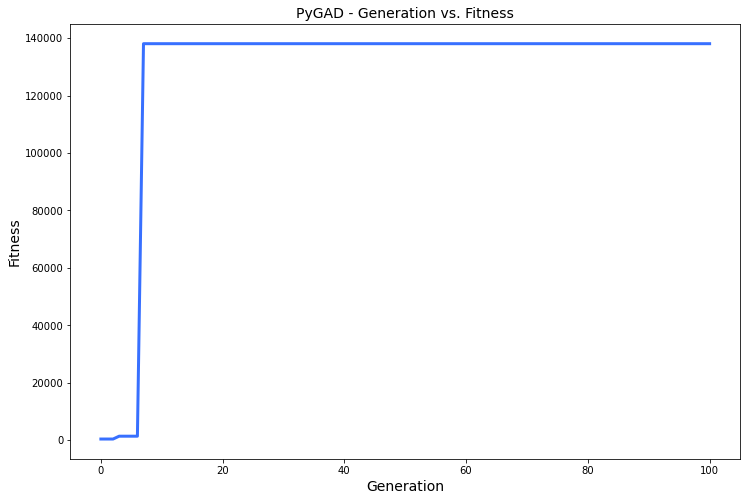

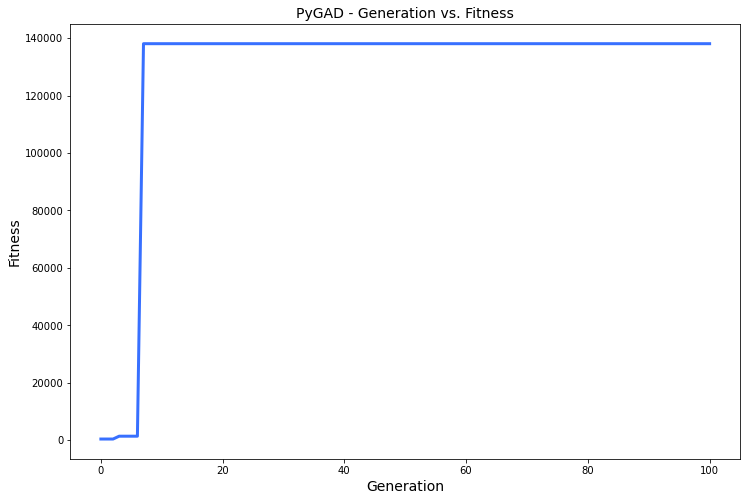

In [12]:
ga_instance.plot_result()

In [13]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.586 |==================| 21.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 26.459 |==================| 12.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 26.41 |==================| 7.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 26.589 |==================| 20.483 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 26.484 |==================| 17.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 26.419 |=============

In [14]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(water_model.FUNCTION_INPUTS)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


Predicted output based on the best solution :0.24998014885755887
Best fitness value reached after 7 generations.


In [15]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,water_model.node]
print(presssure_at_N6)

0    26.540364
Name: N6, dtype: float64


In [16]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.INP_FILE_PATH)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,water_model.node]
print(presssure_at_N6)

0    26.540364
Name: N6, dtype: float64


In [17]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model.TEMP_DIR}GENERATION_*")
water_model.export_results(solutions = solution_per_generation, path='results', name='optimization-result-per-generation')
result_generation = pd.read_csv('results/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: results/optimization-result-per-generation.csv


GENERATION        FITNESS
0         13.0  138071.361655
1         12.0  138071.361655
2         38.0  138071.361655
3         10.0  138071.361655
4          9.0  138071.361655
..         ...            ...
95        37.0  138071.361655
96         6.0    1356.482218
97         7.0  138071.361655
98        36.0  138071.361655
99        22.0  138071.361655

[100 rows x 2 columns]

In [18]:
fitness_solution_per_population = glob.glob(f"{water_model.TEMP_DIR}FITNESS_SOLUTION_*")

water_model.export_results(solutions = fitness_solution_per_population, path='results', name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv('results/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: results/optimization-result-per-fitness.csv


EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND     FITNESS
0                         0.070351        26.607150           10.1   14.971546
1                         0.024745        26.614149           10.1   13.551437
2                         0.366955        26.561204           10.1   47.967148
3                         1.137240        26.438509           10.1    9.818443
4                         1.383939        26.398207           10.1    7.034733
...                            ...              ...            ...         ...
1915                      0.042082        26.611490           10.1   14.057959
1916                      1.247615        26.420537           10.1    8.345760
1917                      1.077436        26.448207           10.1   10.851666
1918                      0.532593        26.535228           10.1  194.920679
1919                      0.832390        26.487642           10.1   18.969494

[1920 rows x 4 columns]

In [19]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='right')
final_data

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
0                       0.499960        26.540364           10.1   
1                       0.499960        26.540364           10.1   
2                       0.499960        26.540364           10.1   
3                       0.499960        26.540364           10.1   
4                       0.499960        26.540364           10.1   
..                           ...              ...            ...   
95                      0.499960        26.540364           10.1   
96                      0.504681        26.539621           10.1   
97                      0.499960        26.540364           10.1   
98                      0.499960        26.540364           10.1   
99                      0.499960        26.540364           10.1   

          FITNESS  GENERATION  
0   138071.361655        13.0  
1   138071.361655        12.0  
2   138071.361655        38.0  
3   138071.361655        10.0  
4   138071.361655         9.0  
..            ...         ...  
95  138071.361655        37.0  
96    1356.482218         6.0  
97  138071.361655         7.0  
98  138071.361655        36.0  
99  138071.361655        22.0  

[100 rows x 5 columns]

In [20]:
# Get a summary statistics after optimization
final_data.describe()

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
count                    100.000000       100.000000   1.000000e+02   
mean                       0.500495        26.540280   1.010000e+01   
std                        0.002577         0.000405   1.606775e-14   
min                        0.499960        26.537646   1.010000e+01   
25%                        0.499960        26.540364   1.010000e+01   
50%                        0.499960        26.540364   1.010000e+01   
75%                        0.499960        26.540364   1.010000e+01   
max                        0.517236        26.540364   1.010000e+01   

             FITNESS  GENERATION  
count     100.000000  100.000000  
mean   129848.712898   50.500000  
std     32710.343927   29.011492  
min       368.682665    1.000000  
25%    138071.361655   25.750000  
50%    138071.361655   50.500000  
75%    138071.361655   75.250000  
max    138071.361655  100.000000

In [21]:
# Check if there are missing values after optimization?
final_data.isna().sum()

EMITTER_COEFFICIENT_SOLUTION    0
PRESSURE_OUTPUT                 0
OUTPUT_DEMAND                   0
FITNESS                         0
GENERATION                      0
dtype: int64

## Plot Results

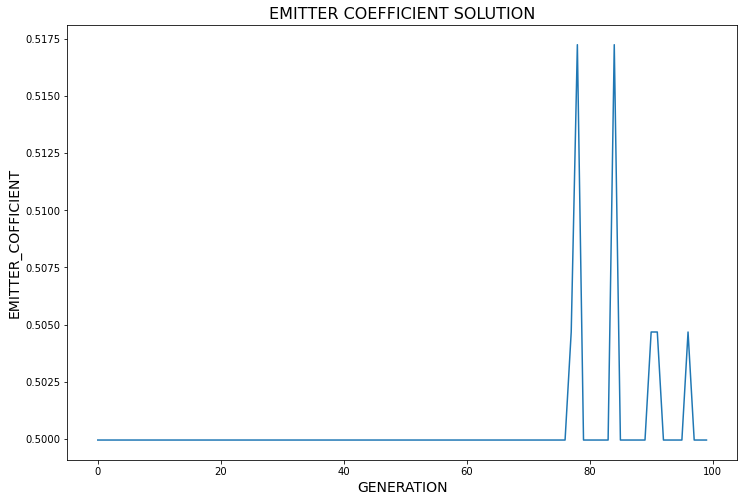

<Figure size 864x576 with 0 Axes>

In [22]:
plt.plot(final_data['EMITTER_COEFFICIENT_SOLUTION'])

plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT SOLUTION',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/EMITTER_COEFFICIENT.png");

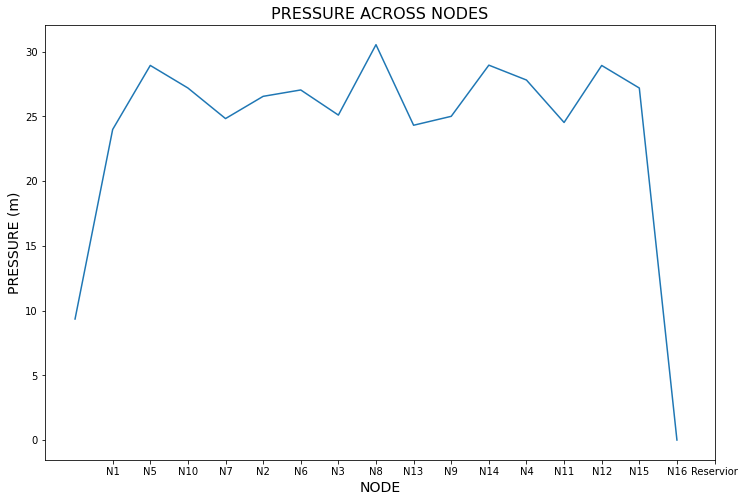

In [23]:
x = list(range(1,len(list(pressure.columns))+1))
plt.plot(list(pressure.values[0,:]))
plt.xlabel('NODE',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE ACROSS NODES',fontsize=16)
plt.xticks(x,list(pressure.columns))
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/Pressure.png")
plt.close()

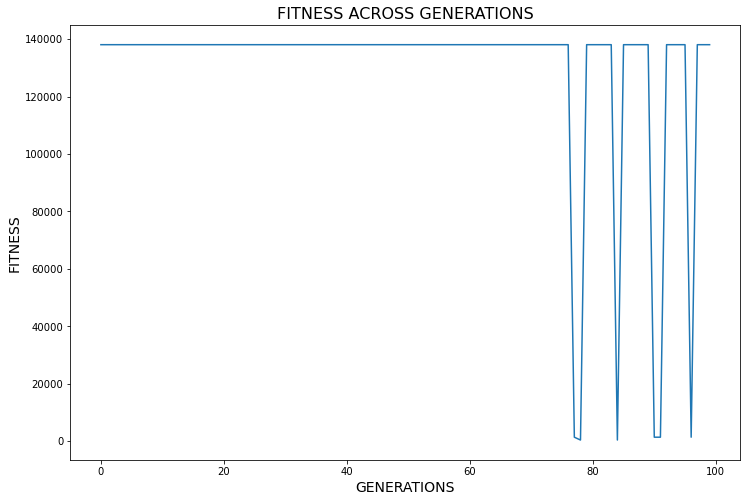

In [27]:
plt.plot(final_data['FITNESS'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/FITNESS_GEN.png")
plt.close()

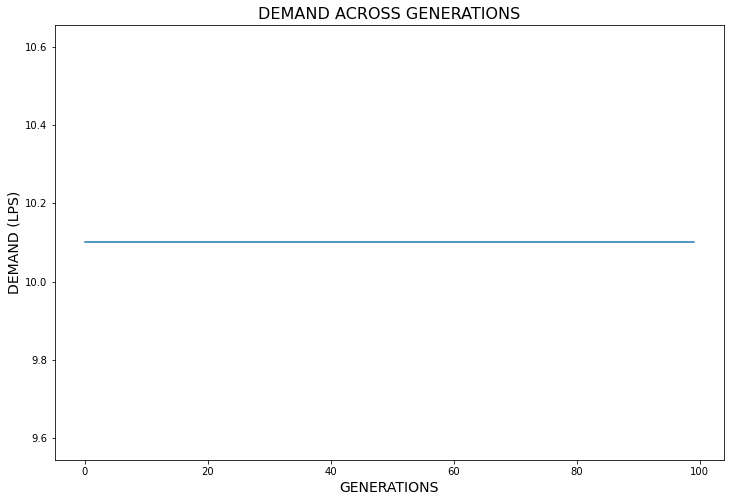

In [25]:
plt.plot(final_data['OUTPUT_DEMAND'])
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.PLOTS_DIR}/DEMAND_VS_GEN.png")
plt.close()